# M.4. Solutions

## Markets Foundations

### UChicago Financial Mathematics

#### September 2022

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

$\newcommand{\rUSD}{r^{\text{US}}}$
$\newcommand{\rGBP}{r^{\text{GBP}}}$
$\newcommand{\rxGBP}{\widetilde{r}^{\text{GBP}}}$

# 1 Stack and Roll

Use the data in `data/futures_data.xlsx`

### 1.1

The time-series data in `futures timeseries` has price data on 4 different crude oil contracts.

Consider a **stack and roll** strategy. 
* Suppose on **November 15, 2021** an investor buys 100 contracts of oil futures, "CLG2", using end-of-day Nov 15, 2021 prices, and noting the contract size listed in the `futures contracts` tab. 

* On the final day of a reported price, (Jan 20, 2022 in this case,) sell the contracts at the listed price. Keep track of the daily profit or loss.
* **Roll** into the next contract, "CLJ2", buying in at the Jan 20, 2022 price.
* Hold this until rolling into CLM2, and finally CLQ2.
* At each roll, buy 100 contracts.
* Close out CLQ2 on June 30, 2022.

Plot the timeseries of cumulative profit and loss.
* Do not consider as a loss (profit) the additional capital contributed (withdrawn) at the roll.

Report the mean daily profit as well as the cumulative total.

### 1.2

From the tab `roll conventions CL`, use the series, `CL1`. 

Assume this is a proxy for the stack and roll strategy above.
* scale it by the contract size (1000)
* calculate the day-over-day differences as profit (loss).

Does it match your answer in 1.1? Why not?

### 1.3
Would any of the alternate continuous contracts in the `roll conventions CL` tab be appropriate to proxy the stack-and-roll strategy?

***

## 2 Margin and Capital

Reconsider the stack and roll of Problem 1, but this time keep track of the margin account. Assume that...
* when purchasing the contracts, an initial margin of \\$10,000 per contract is paid into the margin account, (not the entire purchase price!)
* if the margin account goes below \\$9,000 per contract, you must pay additional capital to raise the margin back to \\$9,000 per contract..
* if the margin account goes above \\$11,000 per contract, you take out the additional capital to lower the margin back to \\$11,000 per contract. 
* at the roll, add in (or take out) capital such that the margin account resets to the initial margin of \\$10,000 per contract.

*This is a conceptually simple problem, but setting it up correctly in python may be challenging. Consider starting with a spreadsheet.*

### 2.1

Plot the timeseries of the margin account.

How many times is there a margin call to continue the contract position? (This does not include rolling contracts.)

### 2.2

Consider two measures of total return on this strategy.

$$\text{return} = \frac{\text{total profit}}{\text{initial capital}}$$

where we measure the "initial capital" as...
* total price of the 100 contracts of "CLG2" as paid in 1.1
* initial margin for the 100 contracts, as calculated in 1.3.

Ignore the fact that additional capital may have been paid in on the rolls.

How does the margin system change the total return?

### 2.3

Reconsider the calculation of profit from Problem 1.

When the contract rolls, the investor may need to pay in additional capital to keep the 100 contracts. Consider this a loss.

On the other hand, if rolling into the new contract frees up capital, consider this a profift.

1. How does this change the total profit (loss)?
1. How does this change the total return defined above?
1. Do you think this roll capital should be considered P&L (profit and loss?)

## 3 Dynamic Sizing

Analyze the investment strategy from Section 1-2 above, but this time assuming that 
* total capital is rolled at each contract, rather than always resetting to a constant 100 contracts.
* the capital is used to purchase as many new contracts as possible, and the remainder sits as cash, (earning no interest,) and available for deployment on the next roll.
* the initial margin is 10\% of the contract value at the time of the roll, the maintenance margin is 9\% and the excess margin is 11\%

# <span style="color:red">Solutions</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

## <span style="color:red">Solution 1</span>

In [2]:
LOADFILE = '../data/futures_data.xlsx'
raw = pd.read_excel(LOADFILE,sheet_name='futures timeseries',header=[0,1]).swaplevel(0,axis=1).set_index(('Unnamed: 0_level_1','Unnamed: 0_level_0'))['LAST_PRICE']
raw.drop(index=['date'],inplace=True)
raw.index.name = 'date'

idcols = ['CL' in col for col in raw.columns]
pxCL = raw[raw.columns[idcols]]
pxCL.index = pd.to_datetime(pxCL.index)

### Build profit (loss) from stack-and-roll

In [3]:
N = 100
SIZE = 1000

DTSTART = '2021-11-15'

T0 = DTSTART
positions = pd.DataFrame(index=pxCL.index, columns=pxCL.columns, dtype=float)
trade = pd.DataFrame(index=pxCL.index, columns=pxCL.columns, dtype=float)

for col in pxCL.columns:
    T1 = pxCL.loc[T0:,col].last_valid_index()
    positions[col].loc[T0:T1] = N * SIZE
    trade[col].loc[T0] = 1
    trade[col].loc[T1] = -1
    T0 = T1    

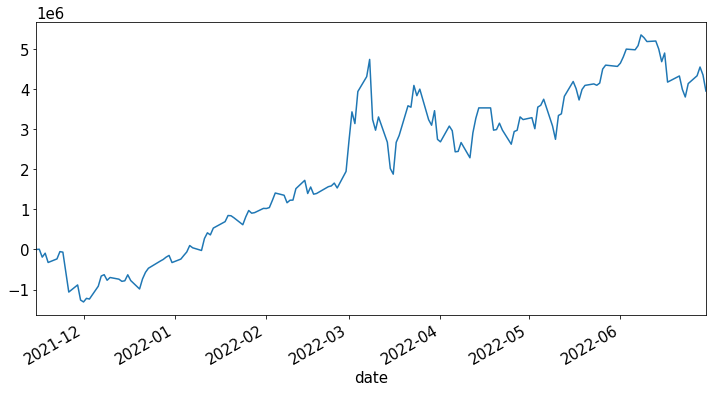

In [4]:
pnlgrid = (positions * pxCL).diff()
pnl = pnlgrid.sum(axis=1)
pnl.name = 'Stack Roll'
pnl.cumsum().plot(xlim=(DTSTART,T1));

### Build P&L from the continuous contracts

In [5]:
continuous = pd.read_excel(LOADFILE,sheet_name='roll conventions CL').set_index('date')
pnl_proxy = (continuous.loc[DTSTART:].diff() * N * SIZE)

### Compare all strategies

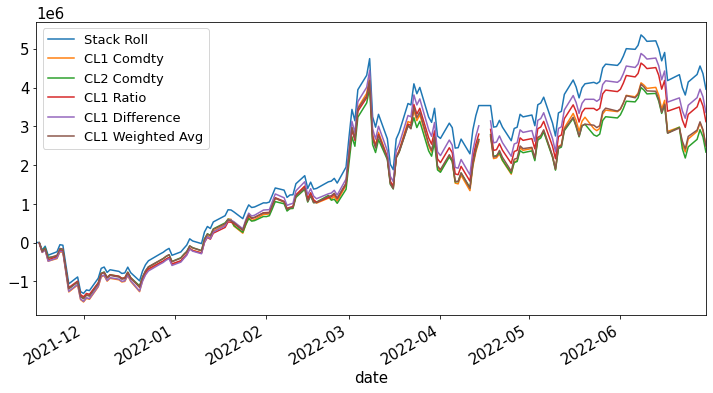

In [6]:
pnl_comp = pd.concat([pnl,pnl_proxy],axis=1)
pnl_comp.cumsum().plot(xlim=(DTSTART,T1));

In [7]:
pnl_comp.sum().to_frame().rename(columns={0:'Total P&L'}).style.format('${:,.0f}')

,Total P&L
Stack Roll,"$3,957,000"
CL1 Comdty,"$2,488,000"
CL2 Comdty,"$2,335,000"
CL1 Ratio,"$3,122,000"
CL1 Difference,"$3,358,000"
CL1 Weighted Avg,"$2,503,000"


### Not surprisingly,

The `diff` version of the continuous ticker best matches the strategy above, where the number of contracts is held constant.
* The `diff` roll is meant to proxy the gains to holding a constant number of contracts.
* It would match exactly if we rolled over with the same timing as the Bloomberg-defined continuous contract.

The basic `CL1 Comdty` continuous contract indicates that the roll down to a lower price is a loss, rather than selling out the old contract and buying into the new contract at a lower price.

## <span style="color:red">Solution 2</span>

This solution is slightly different than the question, as here the margin is replenished to the lower and upper bounds. That is, if the margin account goes below 9, it is replenished to 9, not to 10, as stated in the problem.

In [8]:
M0 = 10 * SIZE * N
MCEIL = 11 * SIZE * N
MFLOOR = 9 * SIZE * N

In [9]:
margin = pd.DataFrame(index=pxCL.index, columns=pxCL.columns, data=0)
distribution = pd.DataFrame(index=pxCL.index, columns=pxCL.columns, data=0)

balance = margin.copy()

T = [margin.loc[DTSTART].name]
for i,col in enumerate(pxCL.columns):
    T.append(pxCL.loc[T[-1]:,col].last_valid_index())

    
    for t in margin.loc[T[-2]:T[-1],col].index:
        if t == T[-2]:
            margin.loc[t,col] = M0
            distribution.loc[t,col] = -M0
        else:
            margin.loc[t,col] = pnlgrid.loc[t,col]
        
        balance.loc[t,col] = margin[col].sum()        

        if t==T[-1]:
            distribution.loc[t,col] = balance.loc[t,col]
            margin.loc[t,col] += -distribution.loc[t,col]

        else:
            if balance.loc[t,col] > MCEIL:
                distribution.loc[t,col] = balance.loc[t,col] - MCEIL
                margin.loc[t,col] += -distribution.loc[t,col]

            elif balance.loc[t,col] < MFLOOR:
                distribution.loc[t,col] = balance[col].loc[t] - MFLOOR
                margin.loc[t,col] += -distribution.loc[t,col]    
        
        balance.loc[t,col] = margin[col].sum()        

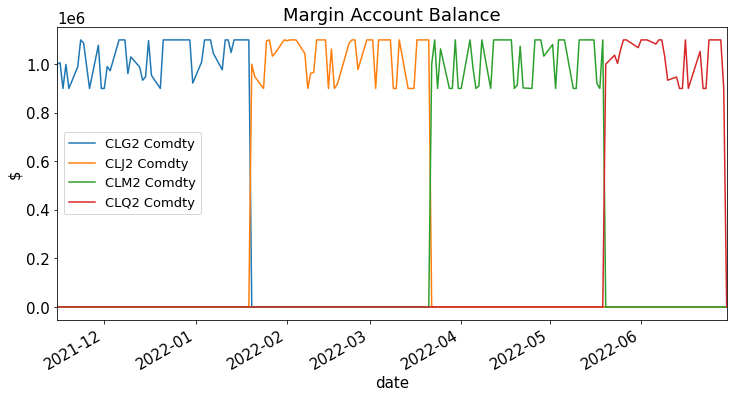

In [10]:
balance.plot(xlim=(T[0],T[-1]),title='Margin Account Balance',ylabel='$');

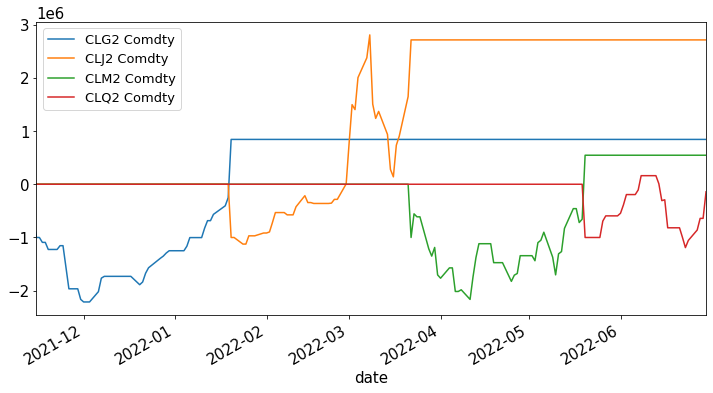

In [11]:
distribution.cumsum().plot(xlim=(T[0],T[-1]));

The next two plot looks at capital usage, plotting the initial purchase as -1e6, then showing how the capital (including profit/loss) changes over time.

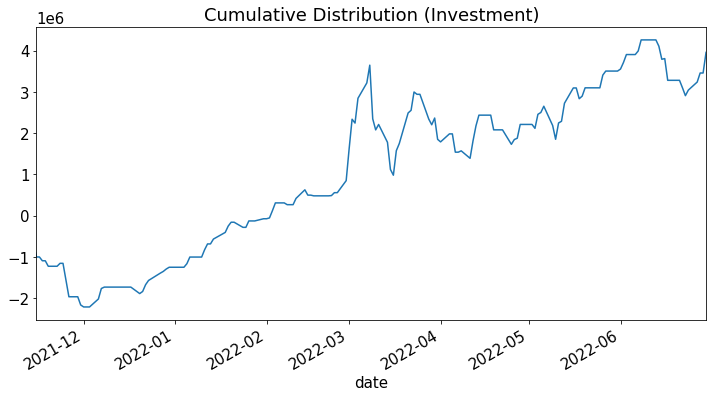

In [12]:
distribution.sum(axis=1).cumsum().plot(xlim=(T[0],T[-1]),title='Cumulative Distribution (Investment)');

In [13]:
summary = pd.DataFrame(dtype=float, index=['fully funded', 'on margin'])
summary.loc['fully funded','initial capital'] = pxCL.iloc[:,0].loc[T[0]] * SIZE * N
summary.loc['on margin','initial capital'] = M0
summary.loc['fully funded', 'total profit'] = pnl.sum()
summary.loc['on margin','total distributions'] = distribution.sum().sum()
summary['total return'] = pnl.sum() / summary['initial capital']
summary.style.format({'initial capital':'${:,.0f}','total profit':'${:,.0f}','total distributions':'${:,.0f}','total return':'{:.1%}'})

,initial capital,total profit,total distributions,total return
fully funded,"$7,848,000","$3,957,000",$nan,50.4%
on margin,"$1,000,000",$nan,"$3,957,000",395.7%
